In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
sns.set(style='white')
sns.set_style('ticks')

### Load and look at data

In [18]:
#Load dataframe and drop duplicate interactions based on standardized characteristics
df = pd.read_csv('features_interactions_merged_types.txt', header=0, index_col=0)
df.drop_duplicates(['EC', 'Org', 'Mode', 'ChEBI', 'Interpro_ids'], inplace=True)

#### Most frequent features

In [20]:
#Count the frequency of the features
top_features = df[['Interpro_ids', 'ENTRY_TYPE', 'ENTRY_NAME']].value_counts().to_frame().reset_index()
top_features.columns = ['Domain', 'Entry type', 'Entry name', 'Count']

In [21]:
#Look at the top 10 features
top_features.head(10)

,Domain,Entry type,Entry name,Count
0,IPR036291,Homologous_superfamily,NAD(P)-binding domain superfamily,1187
1,IPR027417,Homologous_superfamily,P-loop containing nucleoside triphosphate hydr...,822
2,IPR013785,Homologous_superfamily,Aldolase-type TIM barrel,567
3,IPR029044,Homologous_superfamily,Nucleotide-diphospho-sugar transferases,426
4,IPR015421,Homologous_superfamily,"Pyridoxal phosphate-dependent transferase, maj...",421
5,IPR015424,Homologous_superfamily,Pyridoxal phosphate-dependent transferase,420
6,IPR015422,Homologous_superfamily,"Pyridoxal phosphate-dependent transferase, sma...",377
7,IPR036188,Homologous_superfamily,FAD/NAD(P)-binding domain superfamily,293
8,IPR011009,Homologous_superfamily,Protein kinase-like domain superfamily,281
9,IPR011004,Homologous_superfamily,Trimeric LpxA-like superfamily,270


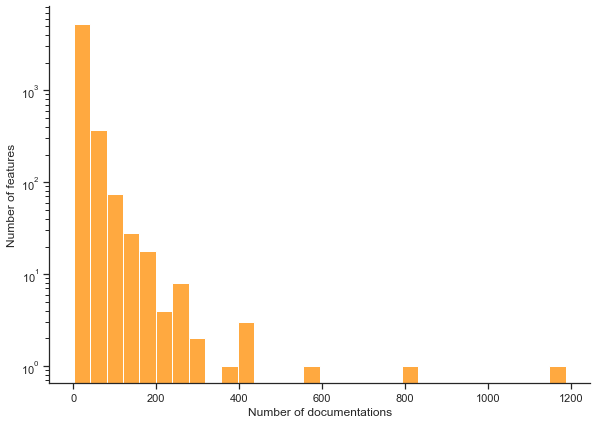

In [22]:
#Plot frequency histogram of features
ax = sns.displot(data=top_features, x='Count', kind='hist', height=6, aspect=1.4, bins=30, log_scale=[False, True], color='darkorange')
ax.set_xlabels('Number of documentations')
ax.set_ylabels('Number of features')

### Fisher's exact test

#### Prepare and perform Fisher's exact test

In [4]:
#Make dictionary of ChEBI ids and synonyms for all metabolites
#Example: CHEBI:15422: {ATP, adenosine triphosphate}
df_mets_grouped = df[['Met', 'ChEBI']].drop_duplicates().groupby(['ChEBI'])['Met'].apply(set).reset_index()
mets_dict = pd.Series(df_mets_grouped.Met.values, index=df_mets_grouped.ChEBI).to_dict()

In [5]:
#Make columns with enzyme info (EC number + organism) and interaction info (ChEBI id + mode) for Fisher's exact test
df['enzyme'] = df['EC'] + ':' + df['Org']
df['interaction'] = df['ChEBI'] + ':' + df['Mode']

In [6]:
#Make dataframe of all enzymes (EC+org) for which a feature (InterPro id) is documented
features = df.groupby('Interpro_ids').agg({'enzyme': set})

#Make dataframe of all enzymes (EC+org) for which an interaction (ChEBI+mode) is documented
interactions = df.groupby('interaction').agg({'enzyme': set})

#Make dataframe of all possible interaction-feature pairs, and sort by number of enzymes (EC+org) for which they are documented
pairs = df.groupby(['interaction', 'Interpro_ids']).agg({'enzyme': len}).sort_values('enzyme', ascending=False)

#Make a set of all enzymes (EC+org)
all_enzymes = set(df['enzyme'])

In [7]:
#Define function for performing one-sided Fisher's exact test
def calculate_fisher_one_sided(f, i):
    with_f = features.loc[f, 'enzyme']
    without_f = all_enzymes - with_f
    with_i = interactions.loc[i, 'enzyme']
    without_i = all_enzymes - with_i

    yy = len(with_f & with_i)
    yn = len(with_f & without_i)
    ny = len(without_f & with_i)
    nn = len(without_f & without_i)

    return fisher_exact([[yy, yn], [ny, nn]], alternative='greater')

In [8]:
#Perform Fisher's exact test on all interaction-feature pairs

data = []

for (i, f) in pairs.index:
    odds, p = calculate_fisher_one_sided(f, i)
    data.append([i, f, odds, p])

df_one_sided = pd.DataFrame(data, columns=['interaction', 'features', 'odds', 'p'])

#### Adjust p-value and odds ratio

In [9]:
#Do fdr correction on p-values to get adjusted p-value (q-value)
df_one_sided['is_significant'], df_one_sided['q'] = fdrcorrection(df_one_sided['p'])

In [10]:
#As the odds ratio for some associations is inifinity, this need to be adjusted for
#This codeline checks if there are any odds higher than 15 000
df_one_sided.query('odds > 15000').sort_values('odds')

,interaction,features,odds,p,is_significant,q
90,CHEBI:14336:-,IPR005999,inf,1.997106e-29,True,1.051349e-25
38854,CHEBI:16238:+,IPR009158,inf,3.109269e-03,True,1.357752e-02
38845,CHEBI:16243:-,IPR035579,inf,2.665087e-02,True,4.849938e-02
38844,CHEBI:16243:-,IPR035574,inf,2.665087e-02,True,4.849938e-02
38843,CHEBI:16243:-,IPR035572,inf,2.665087e-02,True,4.849938e-02
...,...,...,...,...,...,...
21908,CHEBI:57844:-,IPR045785,inf,1.465798e-02,True,3.362091e-02
21907,CHEBI:57844:-,IPR044639,inf,1.465798e-02,True,3.362091e-02
21902,CHEBI:57844:-,IPR042118,inf,1.465798e-02,True,3.362091e-02
21810,CHEBI:57856:-,IPR010049,inf,1.880367e-02,True,3.884533e-02


In [11]:
#Change all odds that are infinity to 15 000
df_one_sided['odds'] = df_one_sided['odds'].apply(lambda x: min(x, 15000))

#### Make volcano plot

In [12]:
#Make columns with log10(odds ratio) and -log10(adj. p-value) 
df_one_sided['log_o'] = np.log10(df_one_sided['odds'])
df_one_sided['log_q'] = -np.log10(df_one_sided['q'])

c:\Users\Elin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='log_o', ylabel='log_q'>

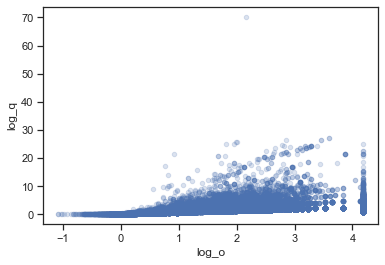

In [14]:
#Plot
df_one_sided.plot.scatter('log_o', 'log_q', alpha=0.2)

### Filter for predicted interactions

In [15]:
#Make dataframe of interactions and features that are associated with q < 0.05 and log10(odds ratio) >= 1
df_predicted = df_one_sided[(df_one_sided['q'] < 0.05) & (df_one_sided['log_o'] >= 1)].drop_duplicates()

In [17]:
#Save the predicted interactions to file
df_predicted.to_csv('predicted_interactions.txt')

### Classify features by name and type

In [23]:
#Get list of entry type and name for InterPro ids, downloaded from the InterPro website
df_entry_list = pd.read_csv('entry.list.txt', sep='\t', header=0)

In [24]:
#Merge dataframe of associated features and interactions with the entry-list
df_merged = pd.merge(df_one_sided, df_entry_list, left_on='features', right_on='ENTRY_AC', how='left').drop('ENTRY_AC', axis=1)

In [25]:
#Add columns for mode, ChEBI id and metabolite name 
df_merged['mode'] = df_merged['interaction'].apply(lambda x: x[-1])

df_merged['ChEBI'] = df_merged['interaction'].apply(lambda x: x[:-2])

df_merged['Met'] = df_merged['ChEBI'].map(mets_dict)

#### Analyse all feature types

In [26]:
#List of all eight feature types in the data
feature_types = ['Active_site', 'Binding_site', 'Conserved_site', 'Domain', 'Family', 'Homologous_superfamily', 'PTM', 'Repeat']

In [27]:
#Make dataframes of interaction-feature associations grouped by feature type
dfs = {type:df_merged.query('ENTRY_TYPE == @type') for type in feature_types}

In [28]:
#Make dataframes of activating interaction-feature associations grouped by feature type
dfs_acts = {type:df_merged.query('ENTRY_TYPE == @type & mode == "+"') for type in feature_types}

In [29]:
#Make dataframes of inhibiting interaction-feature associations grouped by feature type
dfs_inhs = {type:df_merged.query('ENTRY_TYPE == @type & mode == "-"') for type in feature_types}

###### Make functions for plotting histograms of number of interactions/features associated with each feature/interaction

In [37]:
def plot_histogram_features(type, aspect, count_limit=0):
    #Find statistically significant assocations
    df_significant = dfs[type].query('q < 0.05 & log_o >= 1')
    #Make column with interaction given by metabolite name (for easier interpretation)
    df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']

    #Make dataframe of features and their associated interactions, and sort by number of associated interactions

    df_significant_groups = df_significant.groupby(['features'])['interaction'].apply(list).reset_index()

    df_significant_groups['Count'] = df_significant_groups['interaction'].agg(len)
    df_significant_groups = df_significant_groups.sort_values('Count', ascending=False)

    #Plot histogram of number of interactions associated with each feature
    h = sns.catplot(data=df_significant_groups[df_significant_groups['Count'] >= count_limit], x='features', y='Count', kind='bar', aspect=aspect, palette='crest')
    h.set_xticklabels(rotation=90)
    h.set_xlabels(f'{type.replace("_", " ")} (InterPro id)')
    h.set_ylabels('Number of interactions')


In [35]:
def plot_histogram_interactions(type, aspect, count_limit=0):
    #Find statistically significant assocations
    df_significant = dfs[type].query('q < 0.05 & log_o >= 1')
    #Make column with interaction given by metabolite name (for easier interpretation)
    df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']

    #Make dataframe of features and their associated interactions, and sort by number of associated interactions

    df_significant_groups = df_significant.groupby(['interaction(met)'])['features'].apply(list).reset_index()

    df_significant_groups['Count'] = df_significant_groups['features'].agg(len)
    df_significant_groups = df_significant_groups.sort_values('Count', ascending=False)

    #Plot histogram of number of interactions associated with each feature
    h = sns.catplot(data=df_significant_groups[df_significant_groups['Count'] >= count_limit], x='interaction(met)', y='Count', kind='bar', aspect=aspect, palette='flare')
    h.set_xticklabels(rotation=90)
    h.set_xlabels('Interaction')
    h.set_ylabels(f'Number of {type.replace("_", " ").lower()}s')


##### Active sites

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


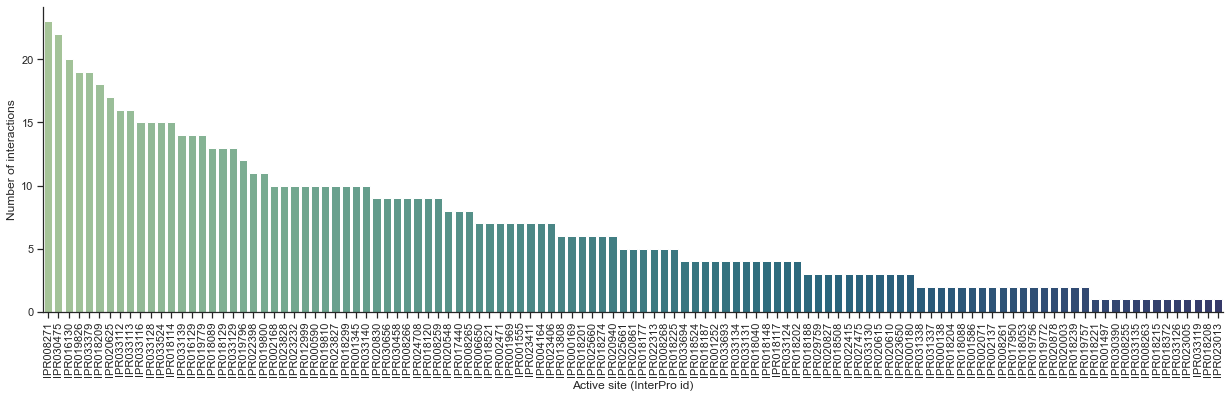

In [38]:
plot_histogram_features(type='Active_site', aspect=3.5)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


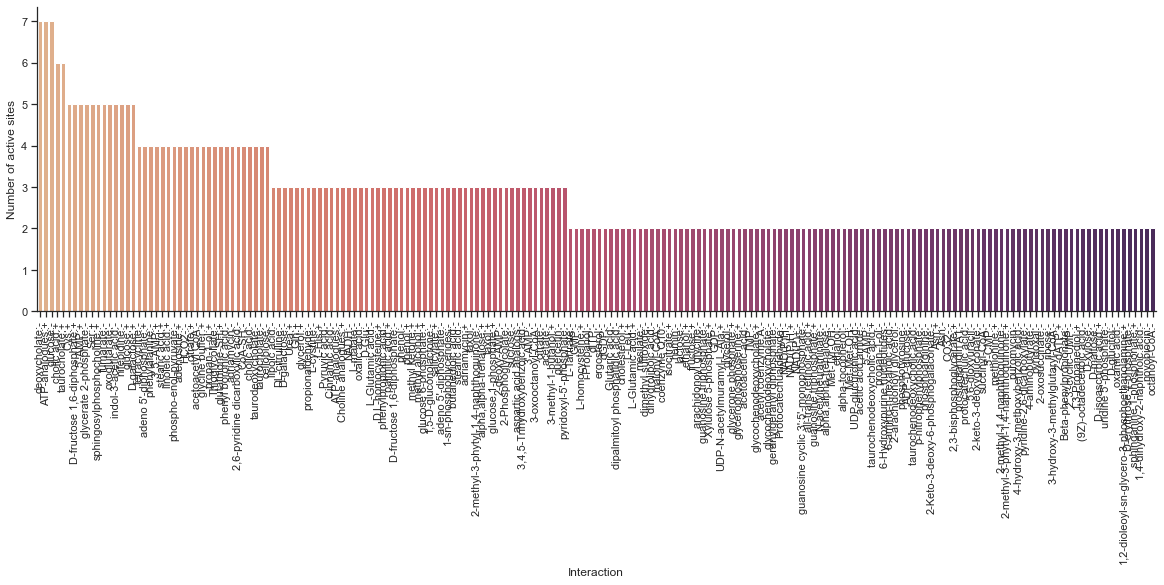

In [40]:
plot_histogram_interactions(type='Active_site', aspect=3.5, count_limit=2)

#### Binding sites

C:\Users\Elin\AppData\Local\Temp\ipykernel_16436\1146821257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


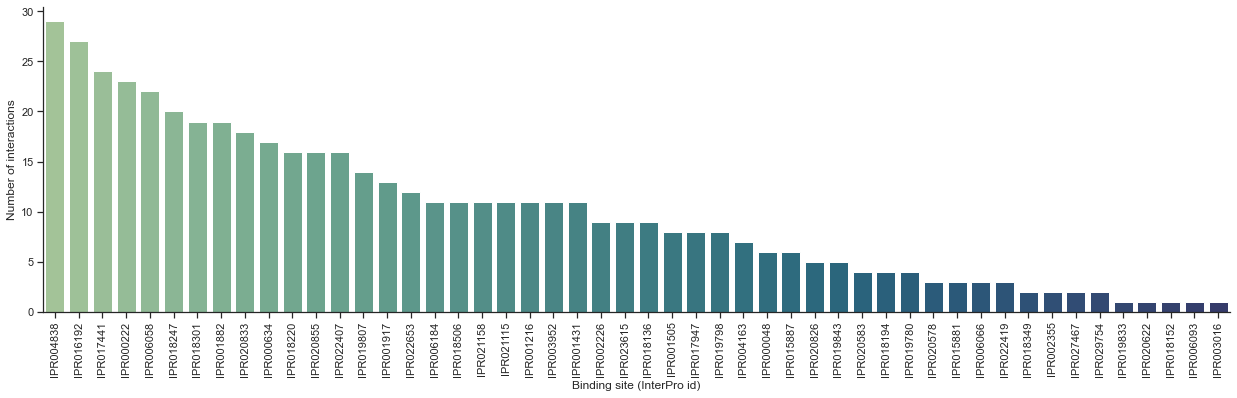

In [155]:
plot_histogram_features(type='Binding_site', aspect=3.5)

C:\Users\Elin\AppData\Local\Temp\ipykernel_16436\3891862147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


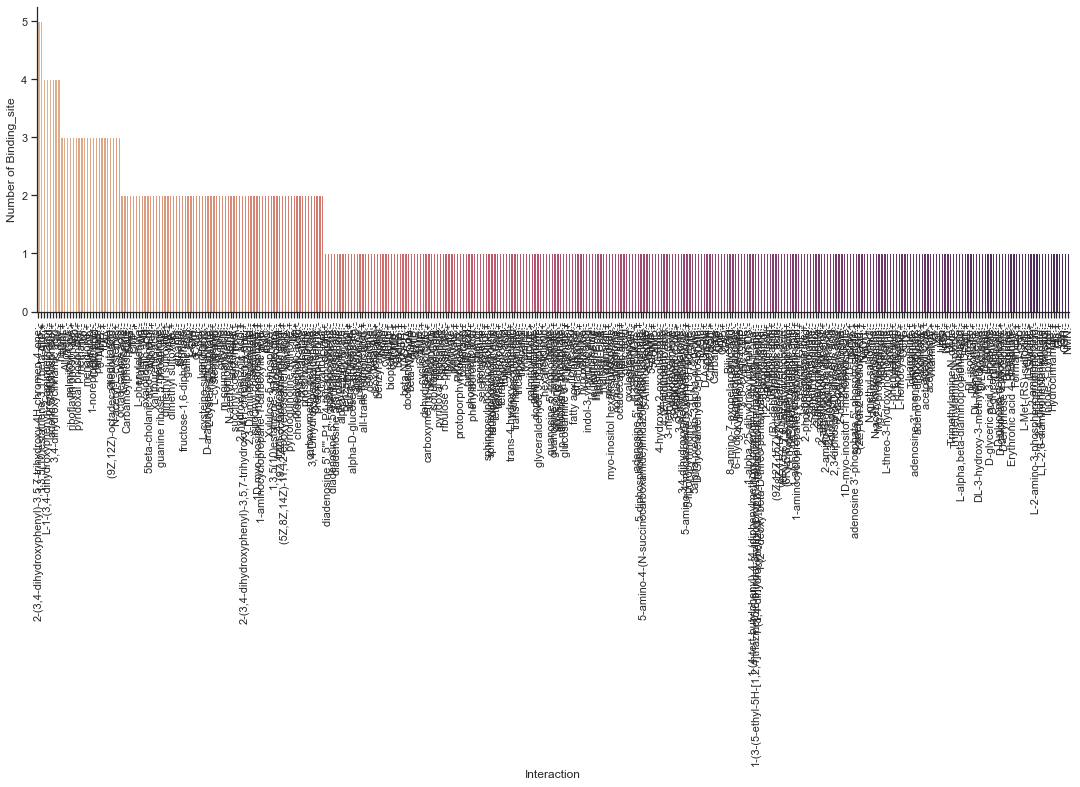

In [156]:
plot_histogram_interactions(type='Binding_site', aspect=3.5)

#### Conserved sites

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


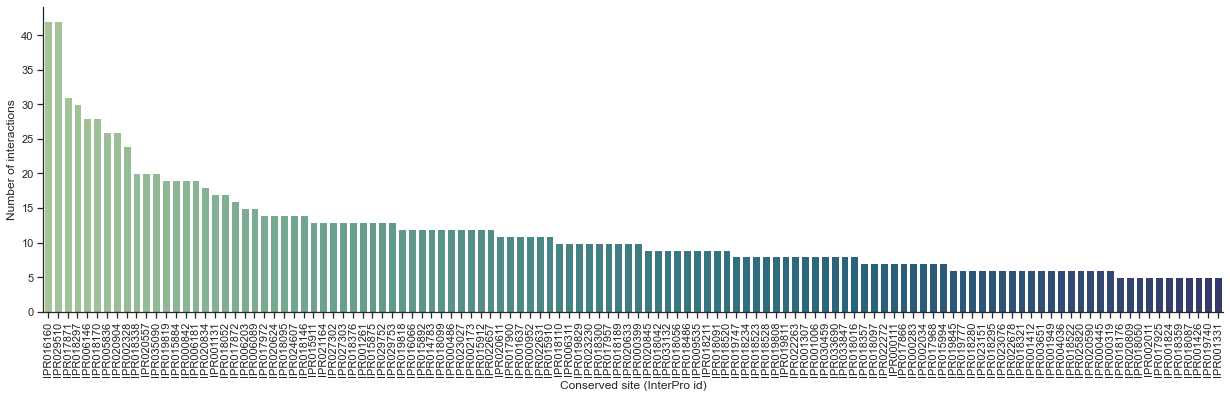

In [45]:
plot_histogram_features(type='Conserved_site', aspect=3.5, count_limit=5)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


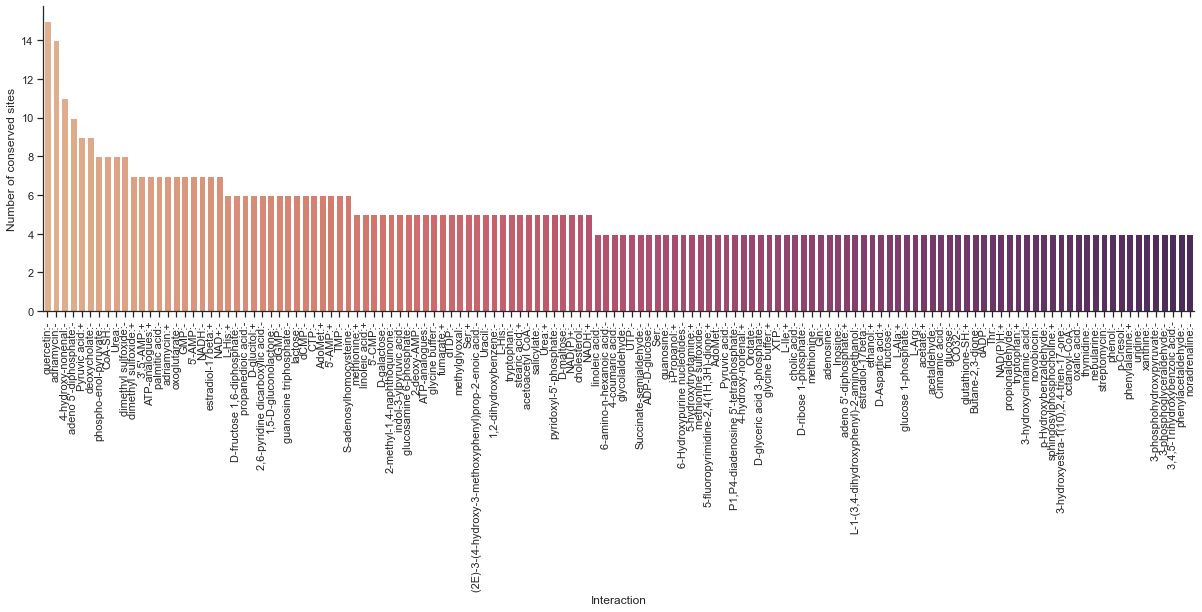

In [49]:
plot_histogram_interactions(type='Conserved_site', aspect=3.5, count_limit=4)

#### Domains

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


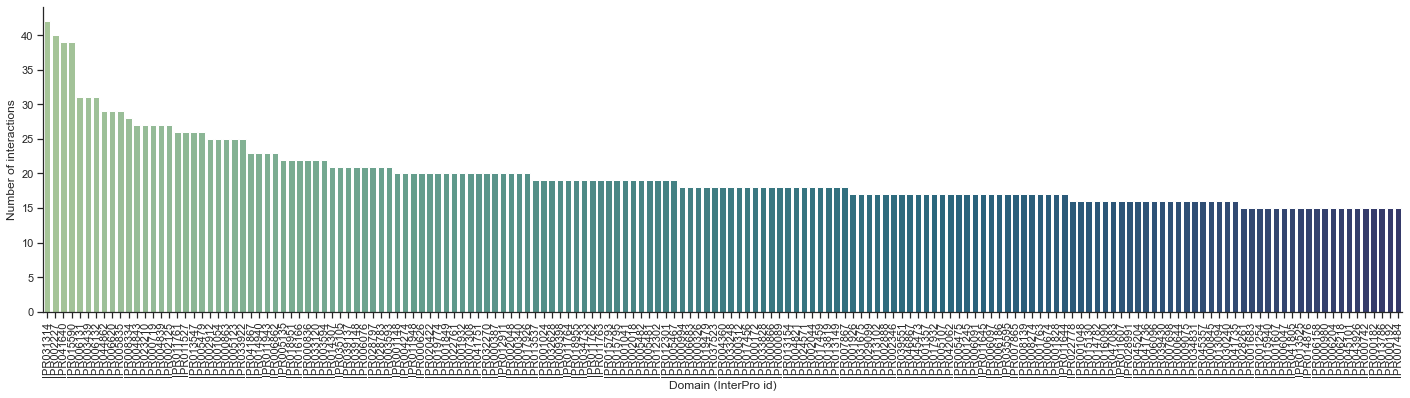

In [72]:
plot_histogram_features(type='Domain', aspect=4, count_limit=15)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


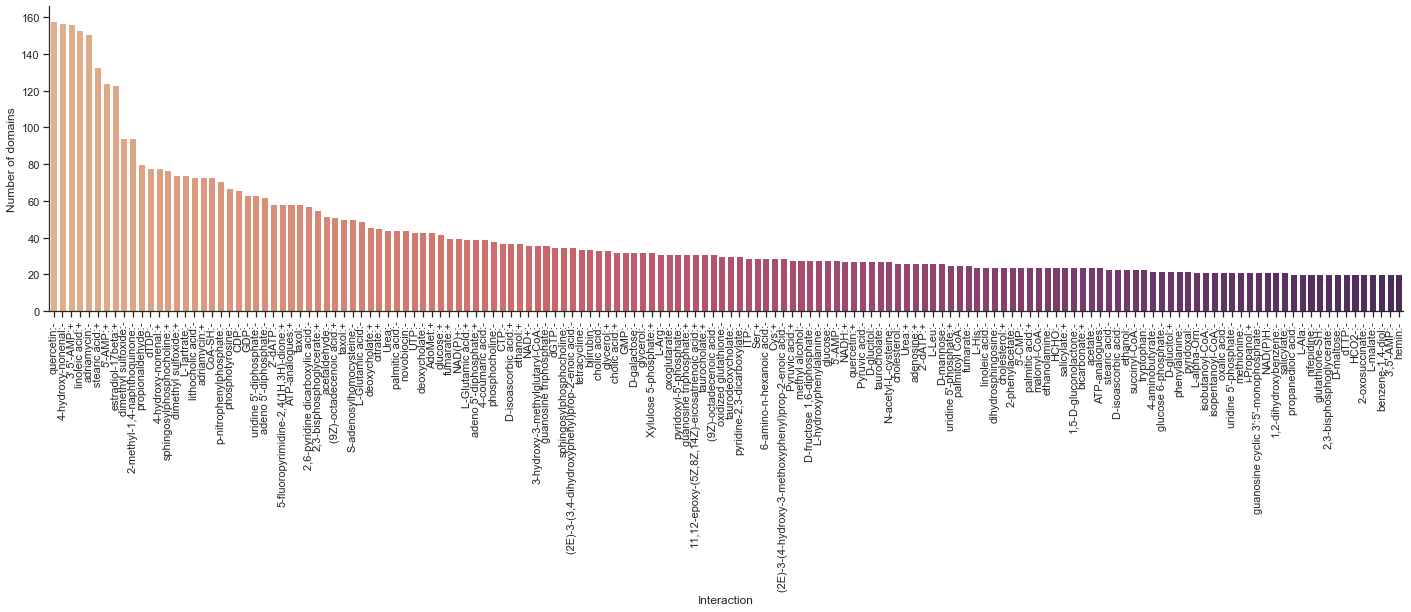

In [74]:
plot_histogram_interactions(type='Domain', aspect=4, count_limit=20)

#### Families

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


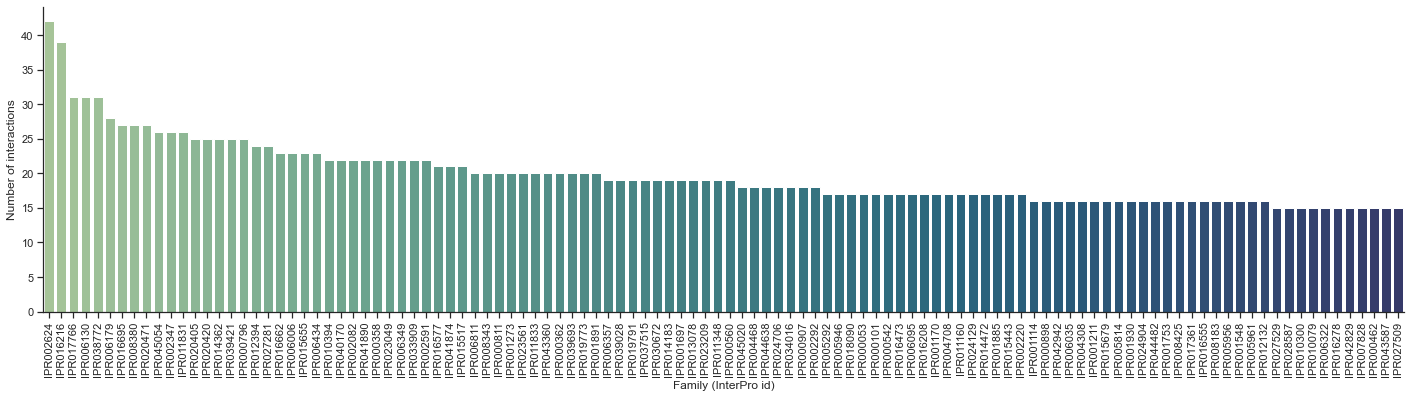

In [68]:
plot_histogram_features(type='Family', aspect=4, count_limit=15)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


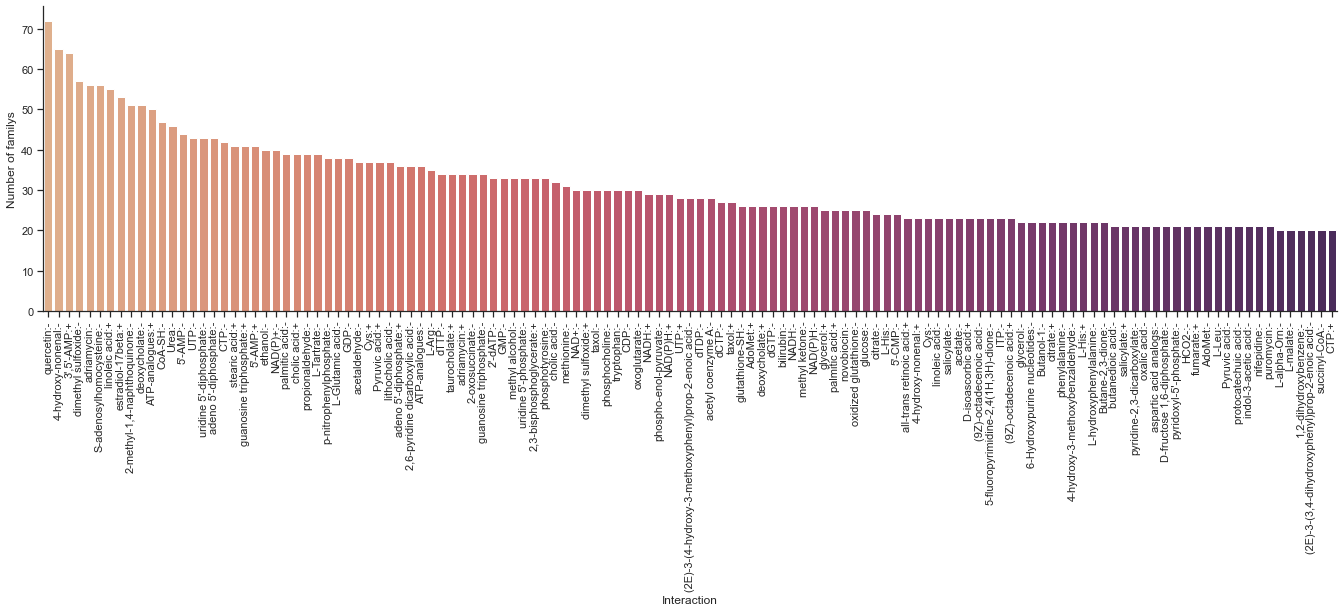

In [69]:
plot_histogram_interactions(type='Family', aspect=4, count_limit=20)

#### Homologous superfamilies

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


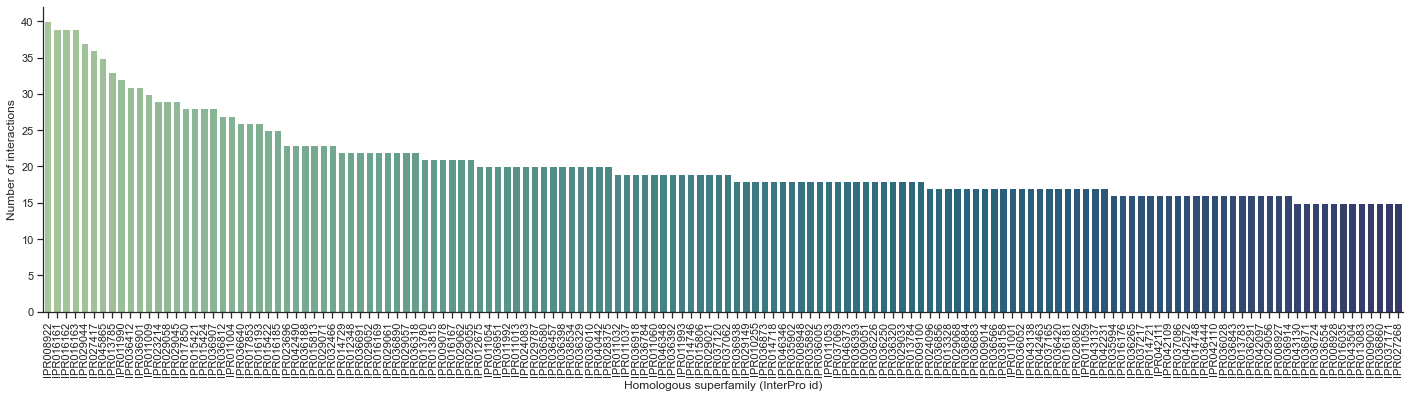

In [61]:
plot_histogram_features(type='Homologous_superfamily', aspect=4, count_limit=15)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


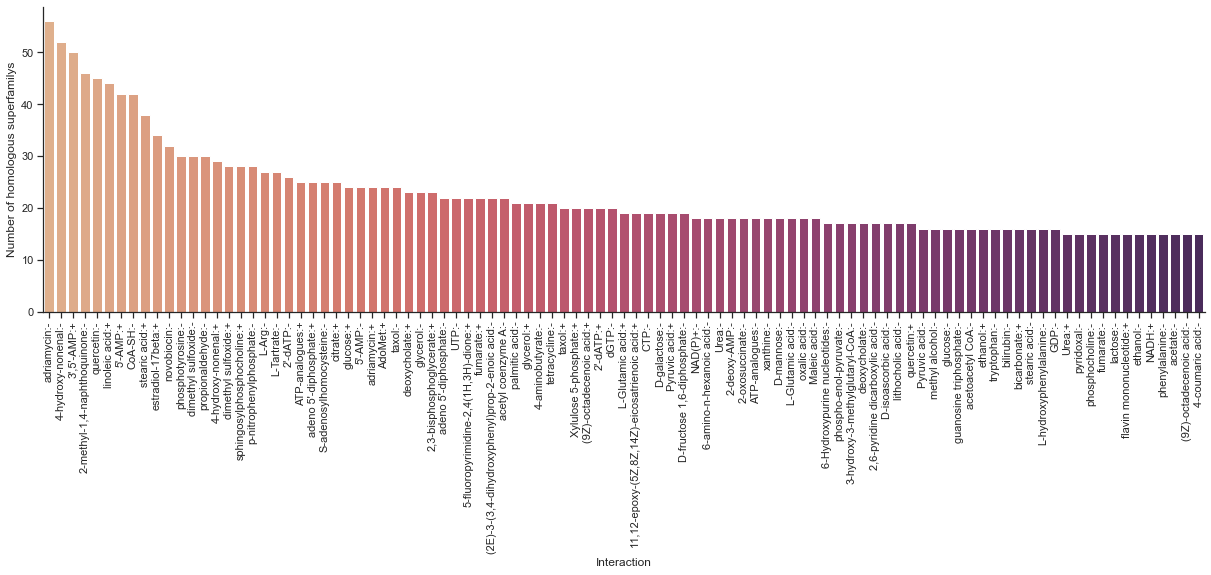

In [70]:
plot_histogram_interactions(type='Homologous_superfamily', aspect=3.5, count_limit=15)

#### PTMs

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


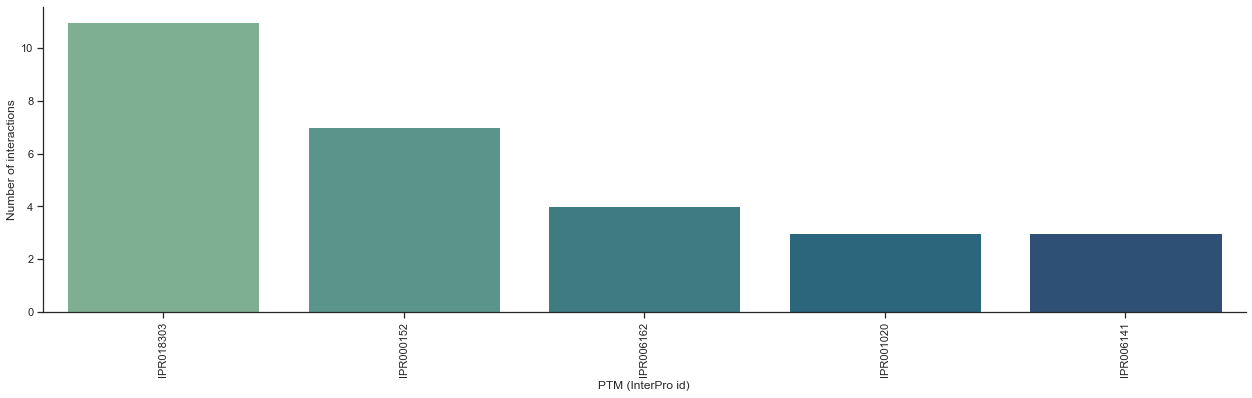

In [57]:
plot_histogram_features(type='PTM', aspect=3.5)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


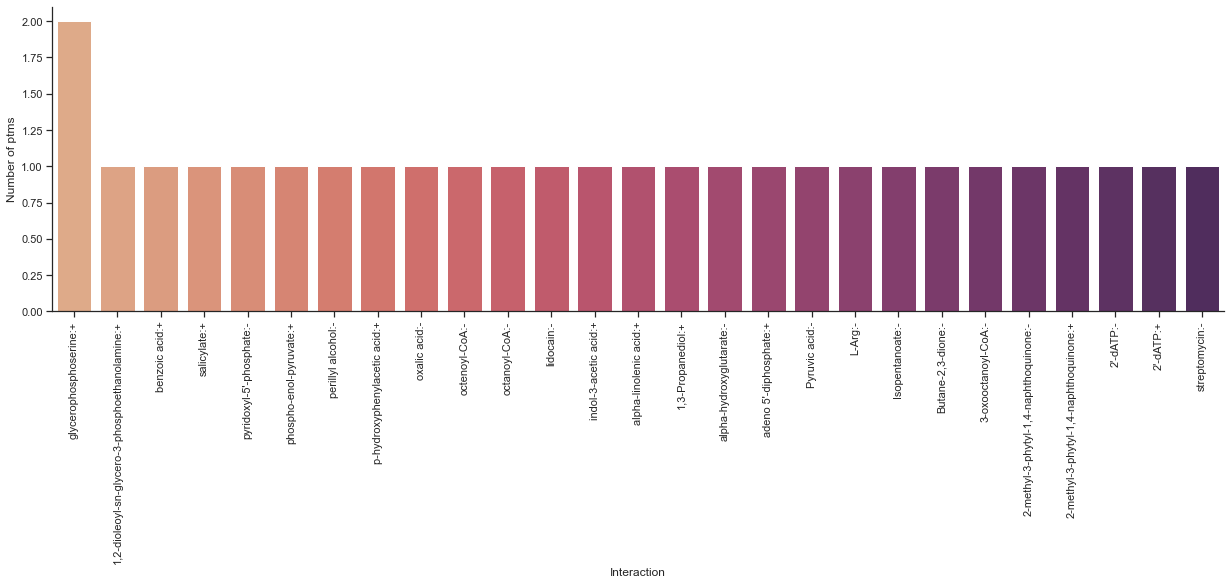

In [58]:
plot_histogram_interactions(type='PTM', aspect=3.5)

#### Repeats

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\1687396535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


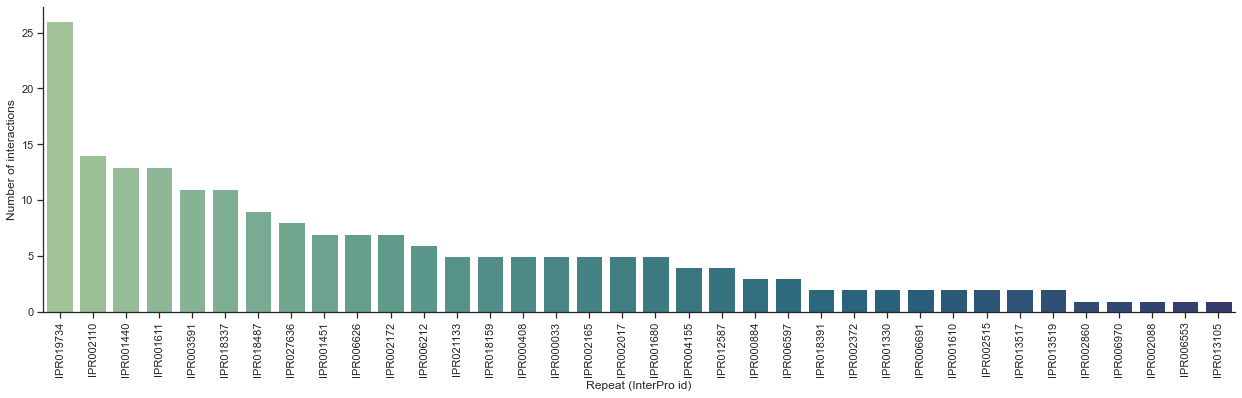

In [55]:
plot_histogram_features(type='Repeat', aspect=3.5)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8300\259133045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


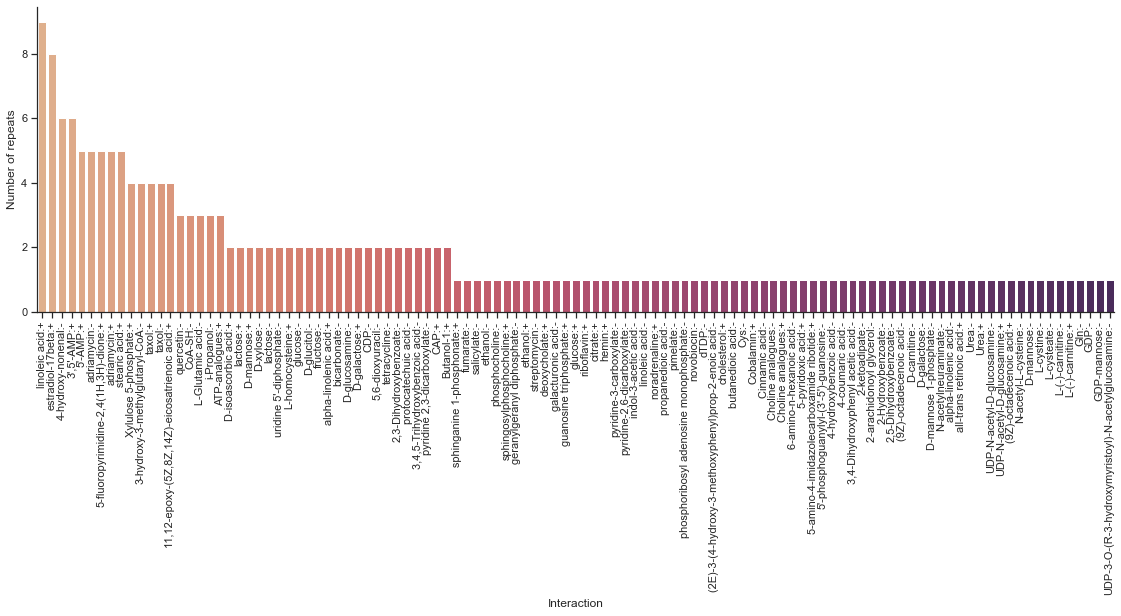

In [56]:
plot_histogram_interactions(type='Repeat', aspect=3.5)

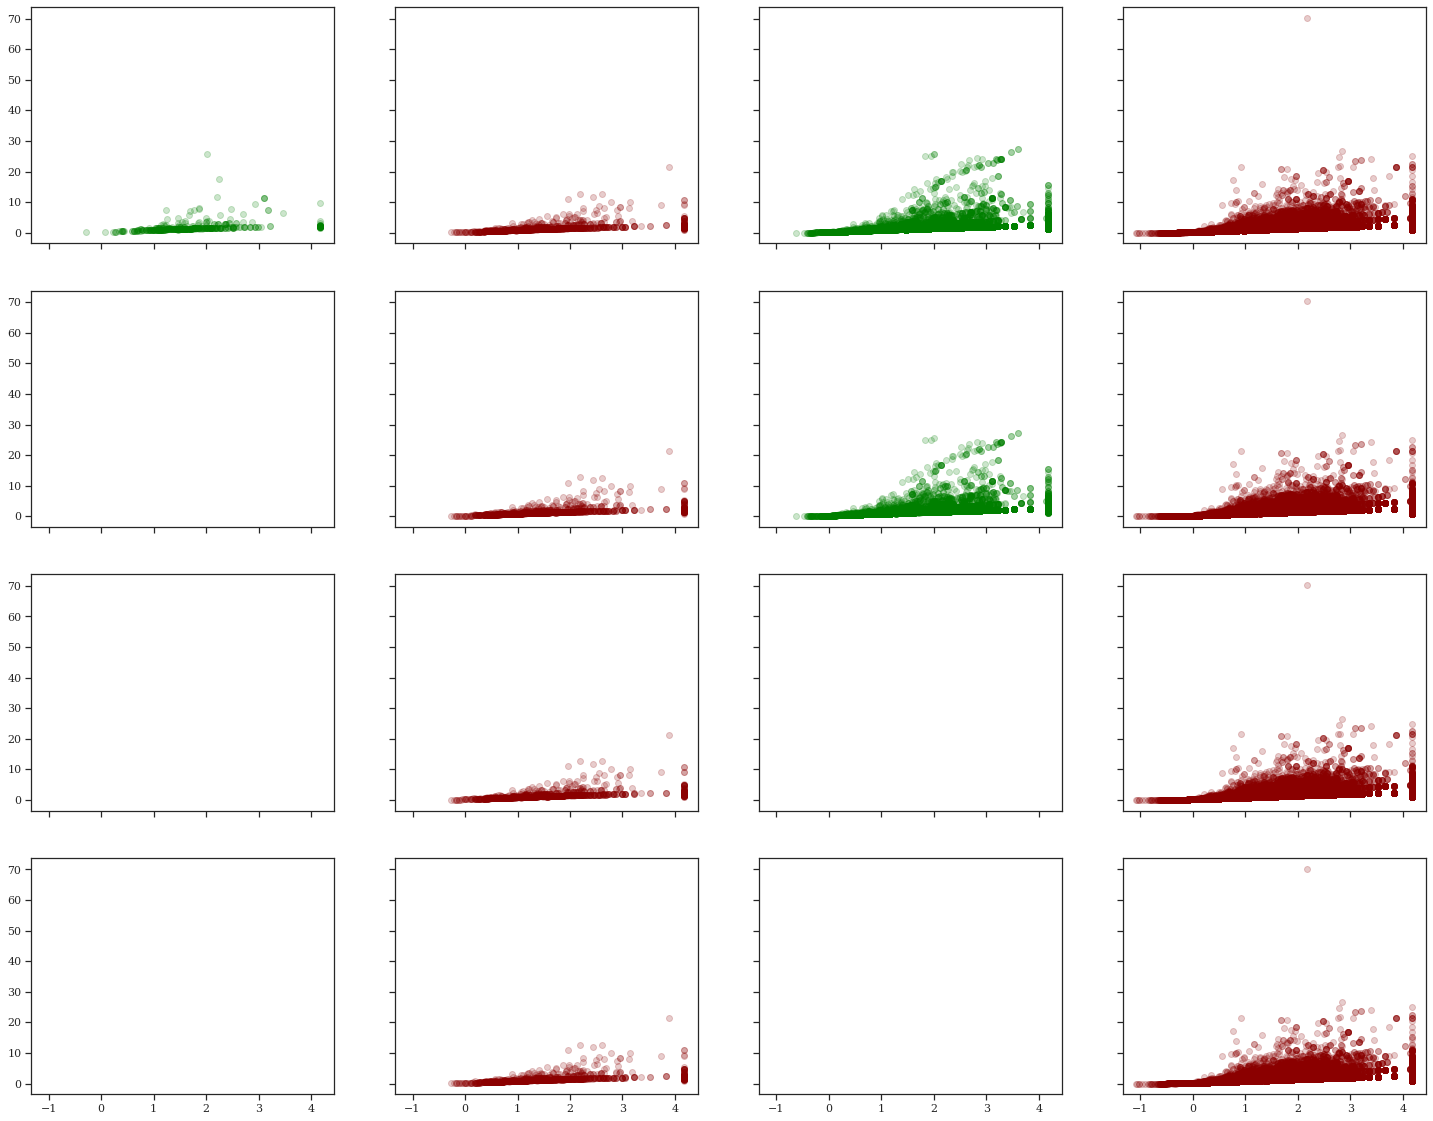

In [95]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharey=True, sharex=True, figsize=(25,20))

c = 0
r = 0


for type in dfs_acts:
    axes[r,c].scatter(dfs_acts[type]['log_o'], dfs_acts[type]['log_q'], color='green', alpha=0.2)
        
    if r < 4: 
        r += 1
    
    c = 2
    r = 0
    axes[r,c].scatter(dfs_acts[type]['log_o'], dfs_acts[type]['log_q'], color='green', alpha=0.2)
    r += 1

r = 0
c = 1
for type in dfs_inhs:
    while r < 4:
        axes[r,c].scatter(dfs_inhs[type]['log_o'], dfs_inhs[type]['log_q'], color='darkred', alpha=0.2)
        r += 1

    c = 3
    r = 0

    axes[r,c].scatter(dfs_inhs[type]['log_o'], dfs_inhs[type]['log_q'], color='darkred', alpha=0.2)
    r += 1

#### Volcano plots

(-1.0, 30.0)

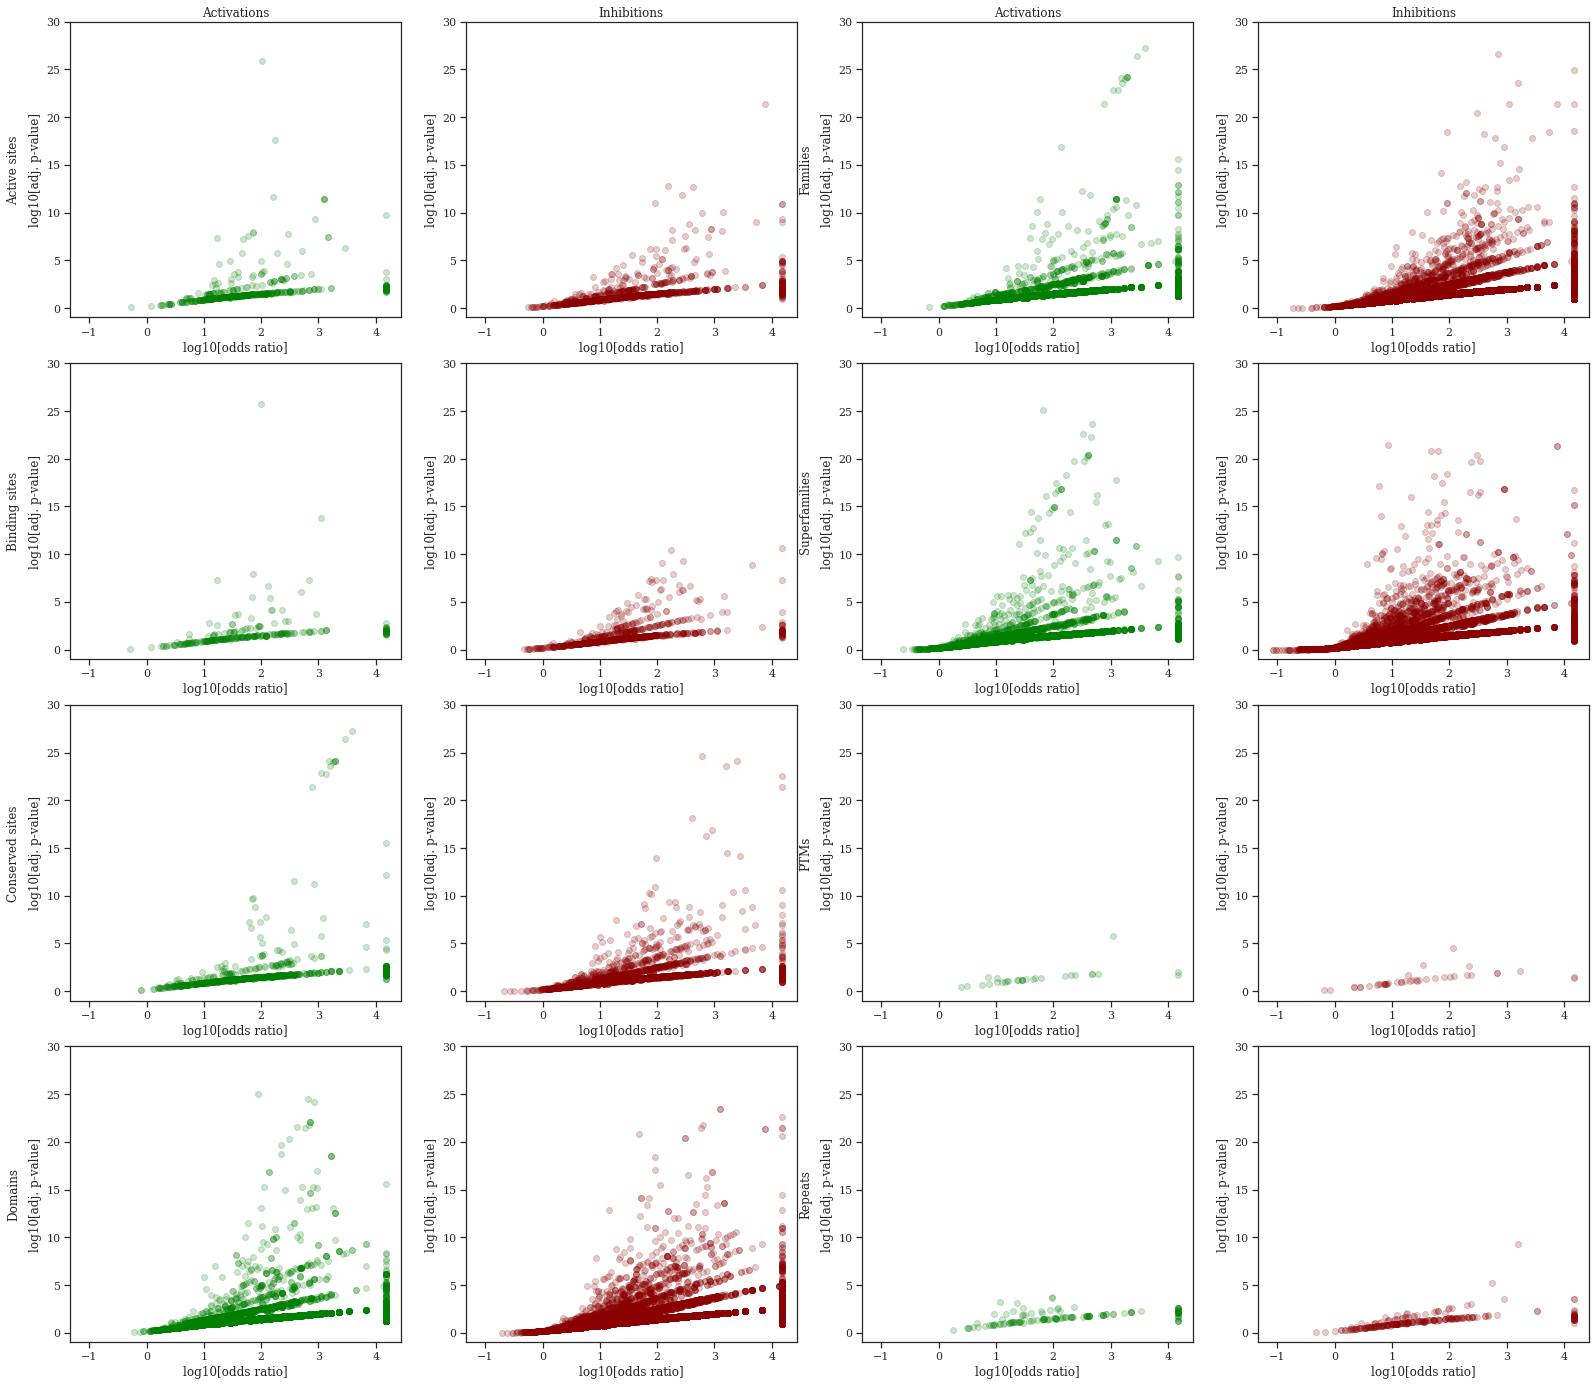

In [101]:
#Create a "superplot" of scatter plots for each feature type to evaluate which feature types has the largest effect
plt.rcParams["font.family"] = "serif"

cols = ['{}'.format(col) for col in ['Activations', 'Inhibitions', 'Activations', 'Inhibitions']]
rows = ['{}'.format(row) for row in ['Active sites', 'Binding sites', 'Conserved sites', 'Domains', 'Families', 'Superfamilies', 'PTMs', 'Repeats']]

fig, axes = plt.subplots(nrows=4, ncols=4, sharey=True, sharex=True, figsize=(25,20))


pad = 5

#Set x- and y-labels for all plots
plt.setp(axes.flat, xlabel='log10[odds ratio]', ylabel='log10[adj. p-value]')

#Add headers (Activations, Inhibitions)
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#Add feature type labels
for ax, row in zip(axes[:,0], rows[:4]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

for ax, row in zip(axes[:,2], rows[4:]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)


#Plot the activating interactions
r, c = 0, 0
for type in dfs_acts:
    axes[r,c].scatter(dfs_acts[type]['log_o'], dfs_acts[type]['log_q'], color='green', alpha=0.2)
    r += 1

    if r == 4:
        r, c = 0, 2

#Plot the inhibiting interactions
r, c = 0, 1
for type in dfs_inhs:
    axes[r,c].scatter(dfs_inhs[type]['log_o'], dfs_inhs[type]['log_q'], color='darkred', alpha=0.2)
    r += 1
    
    if r == 4:
        r, c = 0, 3


for ax in axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.ylim(-1,30)

(-1.0, 30.0)

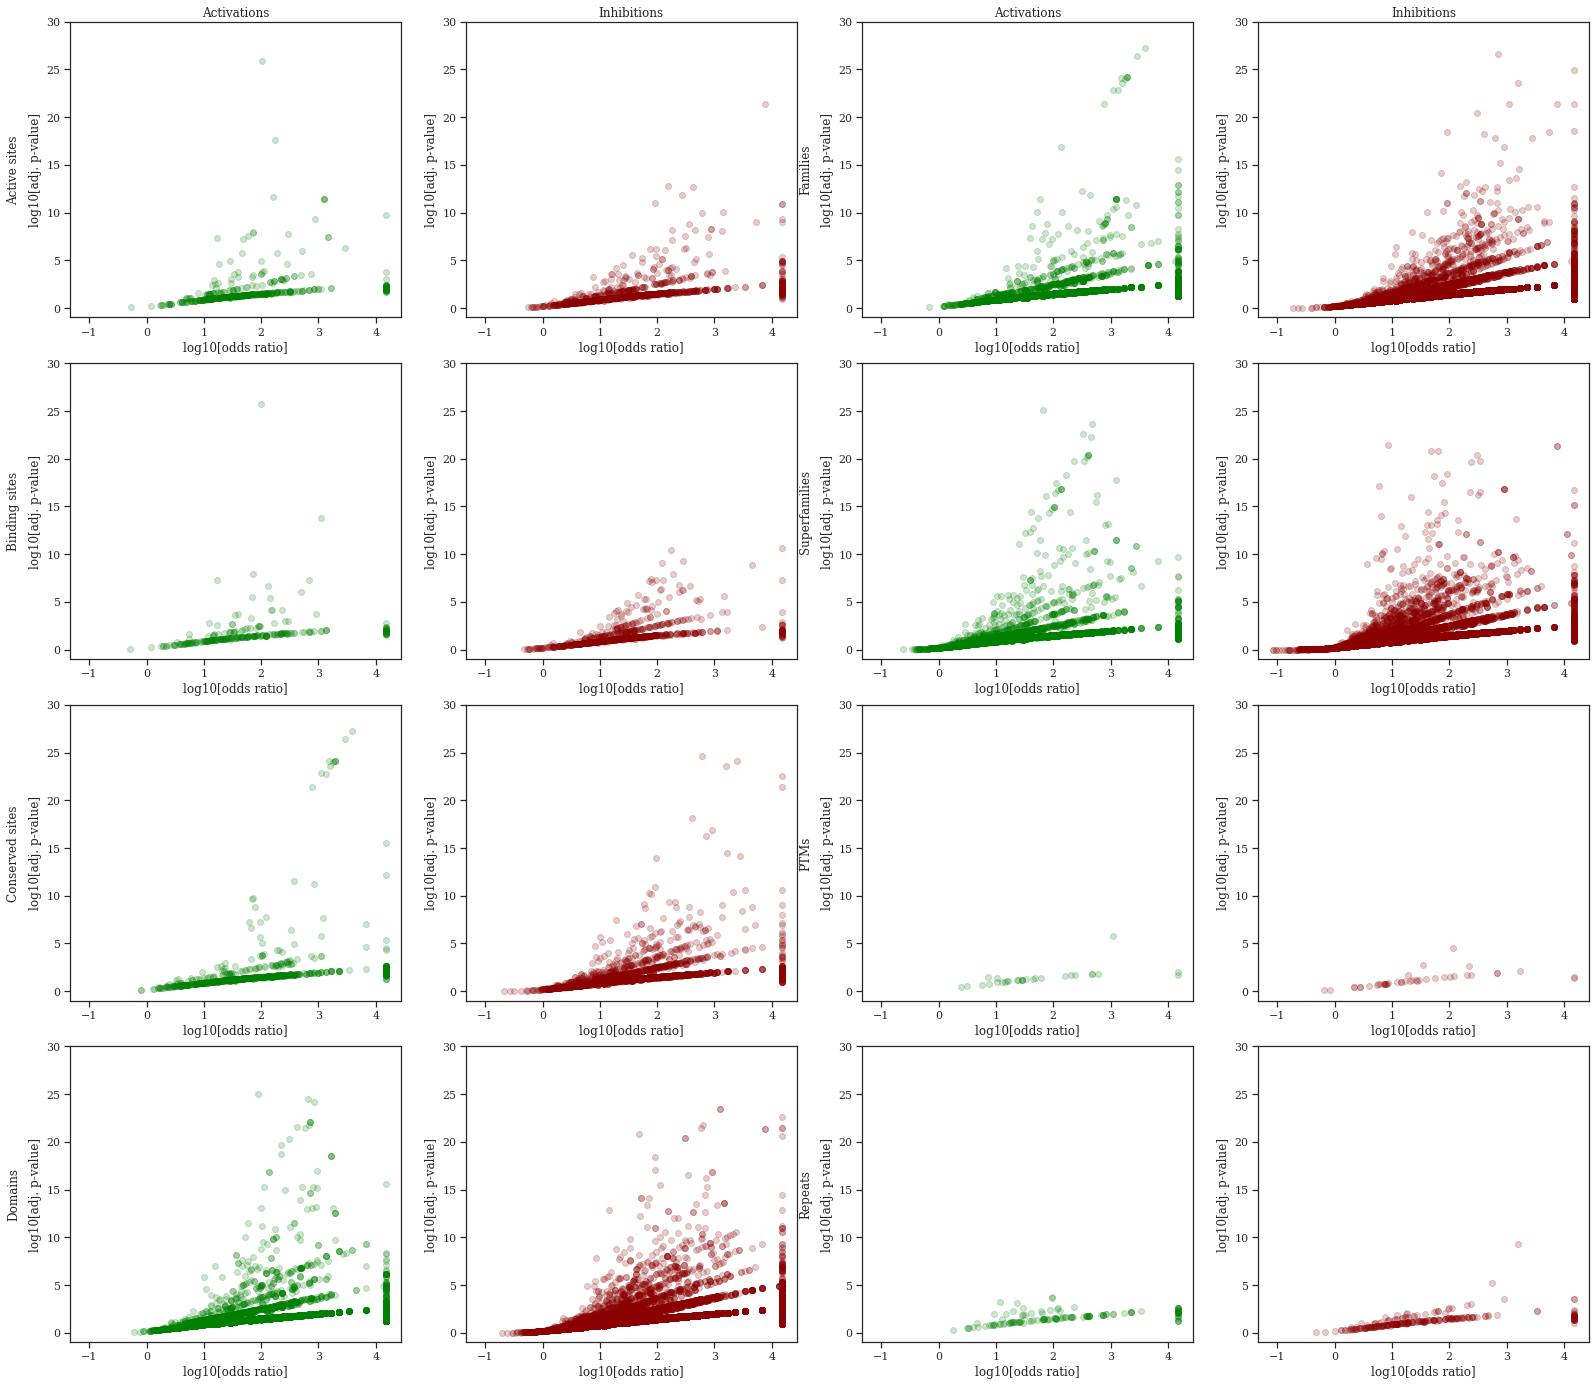

In [161]:
#Create a "superplot" of scatter plots for each feature type to evaluate which feature types has the largest effect
plt.rcParams["font.family"] = "serif"

cols = ['{}'.format(col) for col in ['Activations', 'Inhibitions', 'Activations', 'Inhibitions']]
rows = ['{}'.format(row) for row in ['Active sites', 'Binding sites', 'Conserved sites', 'Domains', 'Families', 'Superfamilies', 'PTMs', 'Repeats']]

fig, axes = plt.subplots(nrows=4, ncols=4, sharey=True, sharex=True, figsize=(25,20))


pad = 5


plt.setp(axes.flat, xlabel='log10[odds ratio]', ylabel='log10[adj. p-value]')

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows[:4]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

for ax, row in zip(axes[:,2], rows[4:]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)


axes[0,0].scatter(dfs_acts['Active_site']['log_o'], dfs_acts['Active_site']['log_q'], color='green', alpha=0.2)
axes[0,1].scatter(dfs_inhs['Active_site']['log_o'], dfs_inhs['Active_site']['log_q'], color='darkred', alpha=0.2)
axes[1,0].scatter(dfs_acts['Binding_site']['log_o'], dfs_acts['Binding_site']['log_q'], color='green', alpha=0.2)
axes[1,1].scatter(dfs_inhs['Binding_site']['log_o'], dfs_inhs['Binding_site']['log_q'], color='darkred', alpha=0.2)
axes[2,0].scatter(dfs_acts['Conserved_site']['log_o'], dfs_acts['Conserved_site']['log_q'], color='green', alpha=0.2)
axes[2,1].scatter(dfs_inhs['Conserved_site']['log_o'], dfs_inhs['Conserved_site']['log_q'], color='darkred', alpha=0.2)
axes[3,0].scatter(dfs_acts['Domain']['log_o'], dfs_acts['Domain']['log_q'], color='green', alpha=0.2)
axes[3,1].scatter(dfs_inhs['Domain']['log_o'], dfs_inhs['Domain']['log_q'], color='darkred', alpha=0.2)
axes[0,2].scatter(dfs_acts['Family']['log_o'], dfs_acts['Family']['log_q'], color='green', alpha=0.2)
axes[0,3].scatter(dfs_inhs['Family']['log_o'], dfs_inhs['Family']['log_q'], color='darkred', alpha=0.2)
axes[1,2].scatter(dfs_acts['Homologous_superfamily']['log_o'], dfs_acts['Homologous_superfamily']['log_q'], color='green', alpha=0.2)
axes[1,3].scatter(dfs_inhs['Homologous_superfamily']['log_o'], dfs_inhs['Homologous_superfamily']['log_q'], color='darkred', alpha=0.2)
axes[2,2].scatter(dfs_acts['PTM']['log_o'], dfs_acts['PTM']['log_q'], color='green', alpha=0.2)
axes[2,3].scatter(dfs_inhs['PTM']['log_o'], dfs_inhs['PTM']['log_q'], color='darkred', alpha=0.2)
axes[3,2].scatter(dfs_acts['Repeat']['log_o'], dfs_acts['Repeat']['log_q'], color='green', alpha=0.2)
axes[3,3].scatter(dfs_inhs['Repeat']['log_o'], dfs_inhs['Repeat']['log_q'], color='darkred', alpha=0.2)

for ax in axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.ylim(-1,30)